In [7]:
import numpy as np 
import pandas as pd
import os
import warnings
import random
import matplotlib.pyplot as plt
import cv2
import pytorch_lightning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import *
import seaborn as sns
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('../../../')

from utils.LungSet import LungSet
from utils.utils import train_model, evaluate_model, generate_preds, build_model, get_available_devices

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed=2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
pwd

'/workspace/lung_challenge/notebooks/cross_validation/no_normalization'

In [9]:
BATCH_SIZE = 2048
num_epochs = 20

transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),    # Randomly flip the image vertically
    transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.001, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [10]:
results = {}

In [5]:
for fold in range(5):
    print(f"Fold: {fold}")
    train_df = pd.read_csv('../../../data/processed/crossval_sets/dataframe_training_Fold' + str(fold) + '.csv')
    test_df = pd.read_csv('../../../data/processed/crossval_sets/dataframe_testing_Fold' + str(fold) + '.csv')
    
    X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
    X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']
    
    trainset = LungSet(X_train, y_train, transforms=transformations, normalize=False)
    testset = LungSet(X_test, y_test, transforms=transformations, normalize=False)

    class_sample_count = list(dict(y_train.value_counts()).values()) # dataset has 10 class-1 samples, 1 class-2 samples, etc.
    weights = (1.0 / torch.Tensor(class_sample_count).double())

    trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader=DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    
    
    OZENCIGA_MODEL_PATH = '../../models/ozenciga_model/tenpercent_resnet18.ckpt'
    model = build_model(OZENCIGA_MODEL_PATH, device)
    devices = get_available_devices()
    if len(devices) > 1:
        model = nn.DataParallel(model, device_ids=[i for i in range(len(devices))])
    device = devices[0]
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights.float().to(device), label_smoothing=0.125)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True, min_lr=1e-7)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    train_f1s = []
    train_f2s = []
    test_f1s = []
    test_f2s = []

    model.eval()
    epoch_loss, epoch_acc, precision, recall, f1, f2 = evaluate_model(model, trainloader, criterion, device)
    test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    train_f1s.append(f1)
    train_f2s.append(f2)
    test_f1s.append(test_f1)
    test_f2s.append(test_f2)
    print(f"Epoch [{0}/{num_epochs}], Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}% -- Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}%")
    print(f"Train Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
    print(f"Test  Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_acc, precision, recall, f1, f2  = train_model(model, trainloader, criterion, optimizer, device)
        model.eval()
        test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
        schedular.step(test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}% -- Test Loss={test_loss:.4f}, Test Acc={test_acc:.3f}%")
        print(f"Train Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
        print(f"Test  Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        train_f1s.append(f1)
        train_f2s.append(f2)
        test_f1s.append(test_f1)
        test_f2s.append(test_f2)
    torch.save(model.state_dict(), f'../models/digilut_model_fine_tuned_with_ozenciga_normalized_fold{fold}.pt')
    torch.save(optimizer.state_dict(), f'../models/digilut_optimizer_fine_tuned_with_ozenciga_normalized_fold{fold}.pt')
    model.eval()
    epoch_loss, epoch_acc, precision, recall, f1, f2 = evaluate_model(model, trainloader, criterion, device)
    test_loss, test_acc, test_precision, test_recall, test_f1, test_f2 = evaluate_model(model, testloader, criterion, device)
    print(f"Train Loss={epoch_loss:.4f}, Acc={epoch_acc:.3f}%, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F2: {f2:.3f}")
    print(f"Test  Loss={test_loss:.4f}, Acc={test_acc:.3f}% Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}, F2: {test_f2:.3f}")

    y_test, y_test_preds = generate_preds(model, testloader, device)
    results[fold] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'train_f1s': train_f1s,
        'train_f2s': train_f2s,
        'test_f1s': test_f1s,
        'test_f2s': test_f2s,
        'y_test': y_test,
        'y_test_preds': y_test_preds
    }
    print('----------------------------------------\n')

Fold: 0
Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:01<00:00, 27.06s/it]


Epoch [0/20], Loss=0.8854, Acc=12.776% -- Test Loss=0.8586, Test Acc=14.744%
Train Precision: 0.882, Recall: 0.128, F1: 0.101, F2: 0.083
Test  Precision: 0.850, Recall: 0.147, F1: 0.110, F2: 0.097


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:57<00:00, 26.88s/it]


Epoch [1/20], Loss=0.7376, Acc=68.929% -- Test Loss=0.6695, Test Acc=82.981%
Train Precision: 0.931, Recall: 0.689, F1: 0.758, F2: 0.698
Test  Precision: 0.936, Recall: 0.830, F1: 0.859, F2: 0.833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:59<00:00, 26.96s/it]


Epoch [2/20], Loss=0.7129, Acc=90.276% -- Test Loss=0.6623, Test Acc=94.271%
Train Precision: 0.955, Recall: 0.903, F1: 0.918, F2: 0.905
Test  Precision: 0.963, Recall: 0.943, F1: 0.948, F2: 0.943


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:48<00:00, 26.43s/it]


Epoch [3/20], Loss=0.7103, Acc=93.363% -- Test Loss=0.6613, Test Acc=95.104%
Train Precision: 0.963, Recall: 0.934, F1: 0.942, F2: 0.935
Test  Precision: 0.967, Recall: 0.951, F1: 0.955, F2: 0.951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:58<00:00, 26.94s/it]


Epoch [4/20], Loss=0.7084, Acc=95.178% -- Test Loss=0.6600, Test Acc=97.843%
Train Precision: 0.969, Recall: 0.952, F1: 0.956, F2: 0.952
Test  Precision: 0.982, Recall: 0.978, F1: 0.979, F2: 0.979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:01<00:00, 27.07s/it]


Epoch [5/20], Loss=0.7073, Acc=96.162% -- Test Loss=0.6596, Test Acc=98.259%
Train Precision: 0.974, Recall: 0.962, F1: 0.965, F2: 0.962
Test  Precision: 0.985, Recall: 0.983, F1: 0.983, F2: 0.983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:49<00:00, 26.48s/it]


Epoch [6/20], Loss=0.7067, Acc=96.810% -- Test Loss=0.6599, Test Acc=97.124%
Train Precision: 0.977, Recall: 0.968, F1: 0.970, F2: 0.968
Test  Precision: 0.977, Recall: 0.971, F1: 0.973, F2: 0.971


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:45<00:00, 26.30s/it]


Epoch [7/20], Loss=0.7061, Acc=97.516% -- Test Loss=0.6592, Test Acc=98.877%
Train Precision: 0.981, Recall: 0.975, F1: 0.977, F2: 0.975
Test  Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:41<00:00, 26.09s/it]


Epoch [8/20], Loss=0.7053, Acc=97.856% -- Test Loss=0.6590, Test Acc=99.001%
Train Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.979
Test  Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:57<00:00, 26.86s/it]


Epoch [9/20], Loss=0.7057, Acc=97.671% -- Test Loss=0.6591, Test Acc=98.481%
Train Precision: 0.982, Recall: 0.977, F1: 0.978, F2: 0.977
Test  Precision: 0.987, Recall: 0.985, F1: 0.985, F2: 0.985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:59<00:00, 26.98s/it]


Epoch [10/20], Loss=0.7052, Acc=98.237% -- Test Loss=0.6587, Test Acc=99.289%
Train Precision: 0.985, Recall: 0.982, F1: 0.983, F2: 0.982
Test  Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:57<00:00, 26.86s/it]


Epoch [11/20], Loss=0.7046, Acc=98.351% -- Test Loss=0.6589, Test Acc=98.648%
Train Precision: 0.986, Recall: 0.984, F1: 0.984, F2: 0.984
Test  Precision: 0.988, Recall: 0.986, F1: 0.987, F2: 0.987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:33<00:00, 25.67s/it]


Epoch [12/20], Loss=0.7049, Acc=98.426% -- Test Loss=0.6586, Test Acc=99.498%
Train Precision: 0.987, Recall: 0.984, F1: 0.985, F2: 0.984
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:48<00:00, 26.41s/it]


Epoch [13/20], Loss=0.7044, Acc=98.788% -- Test Loss=0.6585, Test Acc=99.503%
Train Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:00<00:00, 27.02s/it]


Epoch [14/20], Loss=0.7043, Acc=98.249% -- Test Loss=0.6586, Test Acc=99.120%
Train Precision: 0.985, Recall: 0.982, F1: 0.983, F2: 0.983
Test  Precision: 0.992, Recall: 0.991, F1: 0.991, F2: 0.991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:54<00:00, 26.75s/it]


Epoch [15/20], Loss=0.7043, Acc=98.919% -- Test Loss=0.6584, Test Acc=99.606%
Train Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:56<00:00, 26.83s/it]


Epoch [16/20], Loss=0.7043, Acc=98.941% -- Test Loss=0.6584, Test Acc=99.622%
Train Precision: 0.991, Recall: 0.989, F1: 0.990, F2: 0.989
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:46<00:00, 26.35s/it]


Epoch [17/20], Loss=0.7037, Acc=99.199% -- Test Loss=0.6584, Test Acc=99.516%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:01<00:00, 27.10s/it]


Epoch [18/20], Loss=0.7036, Acc=99.165% -- Test Loss=0.6584, Test Acc=99.299%
Train Precision: 0.992, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:51<00:00, 26.58s/it]


Epoch [19/20], Loss=0.7036, Acc=99.265% -- Test Loss=0.6584, Test Acc=99.377%
Train Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.994, Recall: 0.994, F1: 0.994, F2: 0.994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:56<00:00, 26.83s/it]


Epoch [20/20], Loss=0.7035, Acc=99.298% -- Test Loss=0.6582, Test Acc=99.743%
Train Precision: 0.994, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:45<00:00, 26.29s/it]


Train Loss=0.7029, Acc=99.729%, Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997
Test  Loss=0.6582, Acc=99.723% Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:04<00:00, 27.22s/it]


----------------------------------------

Fold: 1
Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:51<00:00, 26.19s/it]


Epoch [0/20], Loss=0.9056, Acc=91.845% -- Test Loss=0.8685, Test Acc=88.999%
Train Precision: 0.844, Recall: 0.918, F1: 0.879, F2: 0.902
Test  Precision: 0.792, Recall: 0.890, F1: 0.838, F2: 0.869


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:36<00:00, 25.37s/it]


Epoch [1/20], Loss=0.7522, Acc=78.718% -- Test Loss=0.6538, Test Acc=81.953%
Train Precision: 0.937, Recall: 0.787, F1: 0.833, F2: 0.794
Test  Precision: 0.932, Recall: 0.820, F1: 0.850, F2: 0.822


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:40<00:00, 25.60s/it]


Epoch [2/20], Loss=0.7225, Acc=88.816% -- Test Loss=0.6476, Test Acc=95.751%
Train Precision: 0.953, Recall: 0.888, F1: 0.907, F2: 0.891
Test  Precision: 0.969, Recall: 0.958, F1: 0.960, F2: 0.958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:47<00:00, 25.99s/it]


Epoch [3/20], Loss=0.7195, Acc=92.382% -- Test Loss=0.6473, Test Acc=95.534%
Train Precision: 0.960, Recall: 0.924, F1: 0.934, F2: 0.925
Test  Precision: 0.968, Recall: 0.955, F1: 0.959, F2: 0.956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:42<00:00, 25.67s/it]


Epoch [4/20], Loss=0.7175, Acc=94.296% -- Test Loss=0.6464, Test Acc=97.307%
Train Precision: 0.966, Recall: 0.943, F1: 0.949, F2: 0.944
Test  Precision: 0.978, Recall: 0.973, F1: 0.974, F2: 0.973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:49<00:00, 26.10s/it]


Epoch [5/20], Loss=0.7167, Acc=95.483% -- Test Loss=0.6461, Test Acc=97.543%
Train Precision: 0.971, Recall: 0.955, F1: 0.959, F2: 0.955
Test  Precision: 0.980, Recall: 0.975, F1: 0.976, F2: 0.976


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:32<00:00, 25.13s/it]


Epoch [6/20], Loss=0.7158, Acc=96.360% -- Test Loss=0.6457, Test Acc=98.642%
Train Precision: 0.975, Recall: 0.964, F1: 0.967, F2: 0.964
Test  Precision: 0.988, Recall: 0.986, F1: 0.987, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:34<00:00, 25.23s/it]


Epoch [7/20], Loss=0.7152, Acc=97.048% -- Test Loss=0.6456, Test Acc=98.810%
Train Precision: 0.978, Recall: 0.970, F1: 0.972, F2: 0.971
Test  Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:44<00:00, 25.83s/it]


Epoch [8/20], Loss=0.7146, Acc=97.426% -- Test Loss=0.6454, Test Acc=98.637%
Train Precision: 0.980, Recall: 0.974, F1: 0.976, F2: 0.974
Test  Precision: 0.988, Recall: 0.986, F1: 0.987, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:56<00:00, 26.47s/it]


Epoch [9/20], Loss=0.7145, Acc=97.878% -- Test Loss=0.6457, Test Acc=97.645%
Train Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.979
Test  Precision: 0.981, Recall: 0.976, F1: 0.977, F2: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:41<00:00, 25.64s/it]


Epoch [10/20], Loss=0.7143, Acc=98.039% -- Test Loss=0.6454, Test Acc=98.406%
Train Precision: 0.984, Recall: 0.980, F1: 0.981, F2: 0.981
Test  Precision: 0.986, Recall: 0.984, F1: 0.985, F2: 0.984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:54<00:00, 26.37s/it]


Epoch [11/20], Loss=0.7139, Acc=98.293% -- Test Loss=0.6451, Test Acc=99.071%
Train Precision: 0.986, Recall: 0.983, F1: 0.984, F2: 0.983
Test  Precision: 0.991, Recall: 0.991, F1: 0.991, F2: 0.991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:59<00:00, 26.66s/it]


Epoch [12/20], Loss=0.7135, Acc=98.556% -- Test Loss=0.6450, Test Acc=99.527%
Train Precision: 0.988, Recall: 0.986, F1: 0.986, F2: 0.986
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:39<00:00, 25.53s/it]


Epoch [13/20], Loss=0.7134, Acc=98.696% -- Test Loss=0.6449, Test Acc=99.494%
Train Precision: 0.989, Recall: 0.987, F1: 0.987, F2: 0.987
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:50<00:00, 26.12s/it]


Epoch [14/20], Loss=0.7133, Acc=98.842% -- Test Loss=0.6449, Test Acc=99.461%
Train Precision: 0.990, Recall: 0.988, F1: 0.989, F2: 0.988
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:40<00:00, 25.58s/it]


Epoch [15/20], Loss=0.7134, Acc=98.790% -- Test Loss=0.6453, Test Acc=98.500%
Train Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988
Test  Precision: 0.987, Recall: 0.985, F1: 0.985, F2: 0.985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:47<00:00, 25.99s/it]


Epoch [16/20], Loss=0.7129, Acc=99.029% -- Test Loss=0.6450, Test Acc=99.222%
Train Precision: 0.991, Recall: 0.990, F1: 0.991, F2: 0.990
Test  Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:42<00:00, 25.68s/it]


Epoch [17/20], Loss=0.7127, Acc=99.008% -- Test Loss=0.6448, Test Acc=99.409%
Train Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990
Test  Precision: 0.994, Recall: 0.994, F1: 0.994, F2: 0.994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:55<00:00, 26.44s/it]


Epoch [18/20], Loss=0.7129, Acc=99.134% -- Test Loss=0.6447, Test Acc=99.651%
Train Precision: 0.992, Recall: 0.991, F1: 0.992, F2: 0.991
Test  Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:46<00:00, 25.89s/it]


Epoch [19/20], Loss=0.7126, Acc=99.188% -- Test Loss=0.6447, Test Acc=99.580%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:50<00:00, 26.11s/it]


Epoch [20/20], Loss=0.7127, Acc=99.232% -- Test Loss=0.6447, Test Acc=99.863%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.999, Recall: 0.999, F1: 0.999, F2: 0.999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:46<00:00, 25.90s/it]


Train Loss=0.7119, Acc=99.841%, Precision: 0.998, Recall: 0.998, F1: 0.998, F2: 0.998
Test  Loss=0.6448, Acc=99.846% Precision: 0.998, Recall: 0.998, F1: 0.998, F2: 0.998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [08:01<00:00, 26.77s/it]


----------------------------------------

Fold: 2
Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:49<00:00, 26.09s/it]


Epoch [0/20], Loss=0.8833, Acc=30.830% -- Test Loss=0.8440, Test Acc=34.474%
Train Precision: 0.869, Recall: 0.308, F1: 0.387, F2: 0.306
Test  Precision: 0.830, Recall: 0.345, F1: 0.409, F2: 0.336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:38<00:00, 25.45s/it]


Epoch [1/20], Loss=0.7355, Acc=76.471% -- Test Loss=0.6433, Test Acc=79.000%
Train Precision: 0.934, Recall: 0.765, F1: 0.815, F2: 0.772
Test  Precision: 0.925, Recall: 0.790, F1: 0.826, F2: 0.793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:57<00:00, 26.51s/it]


Epoch [2/20], Loss=0.7093, Acc=90.487% -- Test Loss=0.6361, Test Acc=92.904%
Train Precision: 0.955, Recall: 0.905, F1: 0.919, F2: 0.907
Test  Precision: 0.956, Recall: 0.929, F1: 0.936, F2: 0.930


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:45<00:00, 25.87s/it]


Epoch [3/20], Loss=0.7062, Acc=93.621% -- Test Loss=0.6349, Test Acc=94.653%
Train Precision: 0.963, Recall: 0.936, F1: 0.944, F2: 0.937
Test  Precision: 0.963, Recall: 0.947, F1: 0.951, F2: 0.947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:34<00:00, 25.26s/it]


Epoch [4/20], Loss=0.7040, Acc=95.450% -- Test Loss=0.6335, Test Acc=97.407%
Train Precision: 0.970, Recall: 0.955, F1: 0.959, F2: 0.955
Test  Precision: 0.979, Recall: 0.974, F1: 0.975, F2: 0.974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:51<00:00, 26.17s/it]


Epoch [5/20], Loss=0.7031, Acc=96.160% -- Test Loss=0.6331, Test Acc=97.824%
Train Precision: 0.973, Recall: 0.962, F1: 0.965, F2: 0.962
Test  Precision: 0.982, Recall: 0.978, F1: 0.979, F2: 0.978


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:31<00:00, 25.08s/it]


Epoch [6/20], Loss=0.7022, Acc=96.908% -- Test Loss=0.6327, Test Acc=98.800%
Train Precision: 0.977, Recall: 0.969, F1: 0.971, F2: 0.969
Test  Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:29<00:00, 24.97s/it]


Epoch [7/20], Loss=0.7012, Acc=97.564% -- Test Loss=0.6326, Test Acc=98.357%
Train Precision: 0.981, Recall: 0.976, F1: 0.977, F2: 0.976
Test  Precision: 0.986, Recall: 0.984, F1: 0.984, F2: 0.984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:36<00:00, 25.37s/it]


Epoch [8/20], Loss=0.7010, Acc=97.893% -- Test Loss=0.6326, Test Acc=97.962%
Train Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.979
Test  Precision: 0.983, Recall: 0.980, F1: 0.980, F2: 0.980


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:46<00:00, 25.94s/it]


Epoch [9/20], Loss=0.7004, Acc=98.269% -- Test Loss=0.6324, Test Acc=98.736%
Train Precision: 0.986, Recall: 0.983, F1: 0.983, F2: 0.983
Test  Precision: 0.989, Recall: 0.987, F1: 0.988, F2: 0.987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:46<00:00, 25.94s/it]


Epoch [10/20], Loss=0.7000, Acc=98.428% -- Test Loss=0.6321, Test Acc=98.792%
Train Precision: 0.987, Recall: 0.984, F1: 0.985, F2: 0.984
Test  Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:57<00:00, 26.50s/it]


Epoch [11/20], Loss=0.7001, Acc=98.637% -- Test Loss=0.6322, Test Acc=98.450%
Train Precision: 0.988, Recall: 0.986, F1: 0.987, F2: 0.986
Test  Precision: 0.986, Recall: 0.984, F1: 0.985, F2: 0.985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:43<00:00, 25.75s/it]


Epoch [12/20], Loss=0.6997, Acc=98.727% -- Test Loss=0.6319, Test Acc=98.909%
Train Precision: 0.989, Recall: 0.987, F1: 0.988, F2: 0.987
Test  Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [08:02<00:00, 26.83s/it]


Epoch [13/20], Loss=0.6995, Acc=98.895% -- Test Loss=0.6322, Test Acc=98.270%
Train Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989
Test  Precision: 0.985, Recall: 0.983, F1: 0.983, F2: 0.983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:54<00:00, 26.33s/it]


Epoch [14/20], Loss=0.6994, Acc=98.988% -- Test Loss=0.6321, Test Acc=98.593%
Train Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990
Test  Precision: 0.987, Recall: 0.986, F1: 0.986, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:53<00:00, 26.30s/it]


Epoch [15/20], Loss=0.6994, Acc=99.072% -- Test Loss=0.6317, Test Acc=99.240%
Train Precision: 0.992, Recall: 0.991, F1: 0.991, F2: 0.991
Test  Precision: 0.993, Recall: 0.992, F1: 0.993, F2: 0.992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:42<00:00, 25.69s/it]


Epoch [16/20], Loss=0.6995, Acc=99.037% -- Test Loss=0.6318, Test Acc=98.752%
Train Precision: 0.991, Recall: 0.990, F1: 0.991, F2: 0.990
Test  Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:49<00:00, 26.07s/it]


Epoch [17/20], Loss=0.6992, Acc=99.206% -- Test Loss=0.6317, Test Acc=99.170%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.992, Recall: 0.992, F1: 0.992, F2: 0.992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:36<00:00, 25.34s/it]


Epoch [18/20], Loss=0.6991, Acc=99.196% -- Test Loss=0.6316, Test Acc=99.568%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:40<00:00, 25.61s/it]


Epoch [19/20], Loss=0.6988, Acc=99.290% -- Test Loss=0.6316, Test Acc=99.251%
Train Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [08:00<00:00, 26.72s/it]


Epoch [20/20], Loss=0.6987, Acc=99.338% -- Test Loss=0.6316, Test Acc=99.495%
Train Precision: 0.994, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:47<00:00, 25.99s/it]


Train Loss=0.6979, Acc=99.752%, Precision: 0.998, Recall: 0.998, F1: 0.998, F2: 0.998
Test  Loss=0.6315, Acc=99.495% Precision: 0.995, Recall: 0.995, F1: 0.995, F2: 0.995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [08:14<00:00, 27.46s/it]


----------------------------------------

Fold: 3
Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:16<00:00, 24.24s/it]


Epoch [0/20], Loss=0.8945, Acc=84.500% -- Test Loss=0.8643, Test Acc=82.495%
Train Precision: 0.838, Recall: 0.845, F1: 0.842, F2: 0.844
Test  Precision: 0.798, Recall: 0.825, F1: 0.811, F2: 0.819


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:19<00:00, 24.40s/it]


Epoch [1/20], Loss=0.7503, Acc=77.018% -- Test Loss=0.6633, Test Acc=76.725%
Train Precision: 0.933, Recall: 0.770, F1: 0.820, F2: 0.778
Test  Precision: 0.927, Recall: 0.767, F1: 0.811, F2: 0.771


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:20<00:00, 24.47s/it]


Epoch [2/20], Loss=0.7166, Acc=87.891% -- Test Loss=0.6550, Test Acc=93.623%
Train Precision: 0.950, Recall: 0.879, F1: 0.900, F2: 0.882
Test  Precision: 0.960, Recall: 0.936, F1: 0.942, F2: 0.937


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:23<00:00, 24.63s/it]


Epoch [3/20], Loss=0.7127, Acc=91.260% -- Test Loss=0.6536, Test Acc=95.795%
Train Precision: 0.957, Recall: 0.913, F1: 0.925, F2: 0.914
Test  Precision: 0.970, Recall: 0.958, F1: 0.961, F2: 0.958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:25<00:00, 24.72s/it]


Epoch [4/20], Loss=0.7107, Acc=93.649% -- Test Loss=0.6530, Test Acc=96.209%
Train Precision: 0.964, Recall: 0.936, F1: 0.944, F2: 0.937
Test  Precision: 0.972, Recall: 0.962, F1: 0.965, F2: 0.962


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:20<00:00, 24.47s/it]


Epoch [5/20], Loss=0.7096, Acc=95.059% -- Test Loss=0.6521, Test Acc=97.814%
Train Precision: 0.969, Recall: 0.951, F1: 0.956, F2: 0.951
Test  Precision: 0.982, Recall: 0.978, F1: 0.979, F2: 0.978


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.57s/it]


Epoch [6/20], Loss=0.7086, Acc=95.891% -- Test Loss=0.6525, Test Acc=96.595%
Train Precision: 0.972, Recall: 0.959, F1: 0.962, F2: 0.959
Test  Precision: 0.974, Recall: 0.966, F1: 0.968, F2: 0.966


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:19<00:00, 24.43s/it]


Epoch [7/20], Loss=0.7078, Acc=96.878% -- Test Loss=0.6521, Test Acc=97.219%
Train Precision: 0.977, Recall: 0.969, F1: 0.971, F2: 0.969
Test  Precision: 0.978, Recall: 0.972, F1: 0.974, F2: 0.972


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:13<00:00, 24.09s/it]


Epoch [8/20], Loss=0.7076, Acc=97.343% -- Test Loss=0.6517, Test Acc=97.984%
Train Precision: 0.980, Recall: 0.973, F1: 0.975, F2: 0.974
Test  Precision: 0.983, Recall: 0.980, F1: 0.981, F2: 0.980


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:24<00:00, 24.69s/it]


Epoch [9/20], Loss=0.7066, Acc=97.785% -- Test Loss=0.6515, Test Acc=98.356%
Train Precision: 0.982, Recall: 0.978, F1: 0.979, F2: 0.978
Test  Precision: 0.986, Recall: 0.984, F1: 0.984, F2: 0.984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:24<00:00, 24.69s/it]


Epoch [10/20], Loss=0.7066, Acc=97.939% -- Test Loss=0.6513, Test Acc=98.633%
Train Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.980
Test  Precision: 0.988, Recall: 0.986, F1: 0.987, F2: 0.986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:23<00:00, 24.64s/it]


Epoch [11/20], Loss=0.7063, Acc=98.165% -- Test Loss=0.6510, Test Acc=98.877%
Train Precision: 0.985, Recall: 0.982, F1: 0.982, F2: 0.982
Test  Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:20<00:00, 24.45s/it]


Epoch [12/20], Loss=0.7062, Acc=98.442% -- Test Loss=0.6510, Test Acc=98.991%
Train Precision: 0.987, Recall: 0.984, F1: 0.985, F2: 0.984
Test  Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.59s/it]


Epoch [13/20], Loss=0.7058, Acc=98.485% -- Test Loss=0.6509, Test Acc=99.643%
Train Precision: 0.987, Recall: 0.985, F1: 0.985, F2: 0.985
Test  Precision: 0.997, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:17<00:00, 24.31s/it]


Epoch [14/20], Loss=0.7059, Acc=98.735% -- Test Loss=0.6508, Test Acc=99.042%
Train Precision: 0.989, Recall: 0.987, F1: 0.988, F2: 0.987
Test  Precision: 0.991, Recall: 0.990, F1: 0.991, F2: 0.990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:23<00:00, 24.61s/it]


Epoch [15/20], Loss=0.7056, Acc=98.703% -- Test Loss=0.6513, Test Acc=97.995%
Train Precision: 0.989, Recall: 0.987, F1: 0.987, F2: 0.987
Test  Precision: 0.983, Recall: 0.980, F1: 0.981, F2: 0.980


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:19<00:00, 24.41s/it]


Epoch [16/20], Loss=0.7055, Acc=98.874% -- Test Loss=0.6508, Test Acc=99.019%
Train Precision: 0.990, Recall: 0.989, F1: 0.989, F2: 0.989
Test  Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.58s/it]


Epoch [17/20], Loss=0.7052, Acc=98.993% -- Test Loss=0.6508, Test Acc=98.988%
Train Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990
Test  Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.58s/it]


Epoch [18/20], Loss=0.7050, Acc=99.053% -- Test Loss=0.6506, Test Acc=99.359%
Train Precision: 0.991, Recall: 0.991, F1: 0.991, F2: 0.991
Test  Precision: 0.994, Recall: 0.994, F1: 0.994, F2: 0.994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:27<00:00, 24.86s/it]


Epoch [19/20], Loss=0.7049, Acc=99.208% -- Test Loss=0.6511, Test Acc=98.506%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.987, Recall: 0.985, F1: 0.985, F2: 0.985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.59s/it]


Epoch [20/20], Loss=0.7052, Acc=99.134% -- Test Loss=0.6506, Test Acc=99.200%
Train Precision: 0.992, Recall: 0.991, F1: 0.992, F2: 0.991
Test  Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:26<00:00, 24.78s/it]


Train Loss=0.7040, Acc=99.249%, Precision: 0.993, Recall: 0.992, F1: 0.993, F2: 0.993
Test  Loss=0.6506, Acc=99.164% Precision: 0.992, Recall: 0.992, F1: 0.992, F2: 0.992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:30<00:00, 25.03s/it]


----------------------------------------

Fold: 4
Number of GPUs available: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:30<00:00, 24.29s/it]


Epoch [0/20], Loss=0.8860, Acc=10.618% -- Test Loss=0.8825, Test Acc=10.966%
Train Precision: 0.918, Recall: 0.106, F1: 0.058, F2: 0.055
Test  Precision: 0.914, Recall: 0.110, F1: 0.061, F2: 0.058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:59<00:00, 25.69s/it]


Epoch [1/20], Loss=0.7366, Acc=68.405% -- Test Loss=0.7109, Test Acc=82.340%
Train Precision: 0.932, Recall: 0.684, F1: 0.755, F2: 0.693
Test  Precision: 0.942, Recall: 0.823, F1: 0.859, F2: 0.828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:54<00:00, 25.44s/it]


Epoch [2/20], Loss=0.7140, Acc=90.508% -- Test Loss=0.7027, Test Acc=94.973%
Train Precision: 0.955, Recall: 0.905, F1: 0.920, F2: 0.907
Test  Precision: 0.968, Recall: 0.950, F1: 0.955, F2: 0.950


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:55<00:00, 25.49s/it]


Epoch [3/20], Loss=0.7114, Acc=93.565% -- Test Loss=0.7014, Test Acc=96.387%
Train Precision: 0.964, Recall: 0.936, F1: 0.943, F2: 0.937
Test  Precision: 0.975, Recall: 0.964, F1: 0.967, F2: 0.964


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:55<00:00, 25.52s/it]


Epoch [4/20], Loss=0.7097, Acc=95.226% -- Test Loss=0.7010, Test Acc=96.728%
Train Precision: 0.970, Recall: 0.952, F1: 0.957, F2: 0.953
Test  Precision: 0.976, Recall: 0.967, F1: 0.970, F2: 0.968


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:53<00:00, 25.40s/it]


Epoch [5/20], Loss=0.7088, Acc=96.342% -- Test Loss=0.7000, Test Acc=98.424%
Train Precision: 0.975, Recall: 0.963, F1: 0.966, F2: 0.964
Test  Precision: 0.987, Recall: 0.984, F1: 0.985, F2: 0.984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:53<00:00, 25.40s/it]


Epoch [6/20], Loss=0.7081, Acc=97.013% -- Test Loss=0.6997, Test Acc=98.687%
Train Precision: 0.978, Recall: 0.970, F1: 0.972, F2: 0.970
Test  Precision: 0.989, Recall: 0.987, F1: 0.987, F2: 0.987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:47<00:00, 25.11s/it]


Epoch [7/20], Loss=0.7077, Acc=97.497% -- Test Loss=0.7001, Test Acc=97.652%
Train Precision: 0.981, Recall: 0.975, F1: 0.976, F2: 0.975
Test  Precision: 0.982, Recall: 0.977, F1: 0.978, F2: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:42<00:00, 24.88s/it]


Epoch [8/20], Loss=0.7073, Acc=97.860% -- Test Loss=0.6999, Test Acc=97.864%
Train Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.979
Test  Precision: 0.983, Recall: 0.979, F1: 0.980, F2: 0.979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:50<00:00, 25.24s/it]


Epoch [9/20], Loss=0.7071, Acc=98.136% -- Test Loss=0.6999, Test Acc=97.704%
Train Precision: 0.985, Recall: 0.981, F1: 0.982, F2: 0.981
Test  Precision: 0.982, Recall: 0.977, F1: 0.978, F2: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:56<00:00, 25.54s/it]


Epoch [10/20], Loss=0.7064, Acc=98.496% -- Test Loss=0.6991, Test Acc=99.283%
Train Precision: 0.987, Recall: 0.985, F1: 0.986, F2: 0.985
Test  Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:50<00:00, 25.27s/it]


Epoch [11/20], Loss=0.7064, Acc=98.651% -- Test Loss=0.6992, Test Acc=99.061%
Train Precision: 0.988, Recall: 0.987, F1: 0.987, F2: 0.987
Test  Precision: 0.992, Recall: 0.991, F1: 0.991, F2: 0.991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:54<00:00, 25.45s/it]


Epoch [12/20], Loss=0.7063, Acc=98.801% -- Test Loss=0.6990, Test Acc=99.443%
Train Precision: 0.989, Recall: 0.988, F1: 0.988, F2: 0.988
Test  Precision: 0.995, Recall: 0.994, F1: 0.995, F2: 0.994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:56<00:00, 25.54s/it]


Epoch [13/20], Loss=0.7060, Acc=98.941% -- Test Loss=0.6988, Test Acc=99.602%
Train Precision: 0.991, Recall: 0.989, F1: 0.990, F2: 0.989
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:58<00:00, 25.64s/it]


Epoch [14/20], Loss=0.7055, Acc=98.962% -- Test Loss=0.6988, Test Acc=99.598%
Train Precision: 0.991, Recall: 0.990, F1: 0.990, F2: 0.990
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:58<00:00, 25.63s/it]


Epoch [15/20], Loss=0.7055, Acc=99.232% -- Test Loss=0.6988, Test Acc=99.758%
Train Precision: 0.993, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.998, Recall: 0.998, F1: 0.998, F2: 0.998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:56<00:00, 25.55s/it]


Epoch [16/20], Loss=0.7056, Acc=99.158% -- Test Loss=0.6989, Test Acc=99.826%
Train Precision: 0.992, Recall: 0.992, F1: 0.992, F2: 0.992
Test  Precision: 0.998, Recall: 0.998, F1: 0.998, F2: 0.998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:55<00:00, 25.52s/it]


Epoch [17/20], Loss=0.7055, Acc=99.144% -- Test Loss=0.6988, Test Acc=99.407%
Train Precision: 0.992, Recall: 0.991, F1: 0.992, F2: 0.991
Test  Precision: 0.994, Recall: 0.994, F1: 0.994, F2: 0.994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:38<00:00, 24.71s/it]


Epoch [18/20], Loss=0.7053, Acc=99.346% -- Test Loss=0.6987, Test Acc=99.600%
Train Precision: 0.994, Recall: 0.993, F1: 0.994, F2: 0.993
Test  Precision: 0.996, Recall: 0.996, F1: 0.996, F2: 0.996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [09:03<00:00, 25.86s/it]


Epoch [19/20], Loss=0.7055, Acc=99.293% -- Test Loss=0.6986, Test Acc=99.680%
Train Precision: 0.993, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:53<00:00, 25.39s/it]


Epoch [20/20], Loss=0.7053, Acc=99.328% -- Test Loss=0.6986, Test Acc=99.741%
Train Precision: 0.994, Recall: 0.993, F1: 0.993, F2: 0.993
Test  Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:43<00:00, 24.95s/it]


Train Loss=0.7045, Acc=99.743%, Precision: 0.998, Recall: 0.997, F1: 0.997, F2: 0.997
Test  Loss=0.6986, Acc=99.734% Precision: 0.997, Recall: 0.997, F1: 0.997, F2: 0.997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [08:52<00:00, 25.38s/it]


----------------------------------------



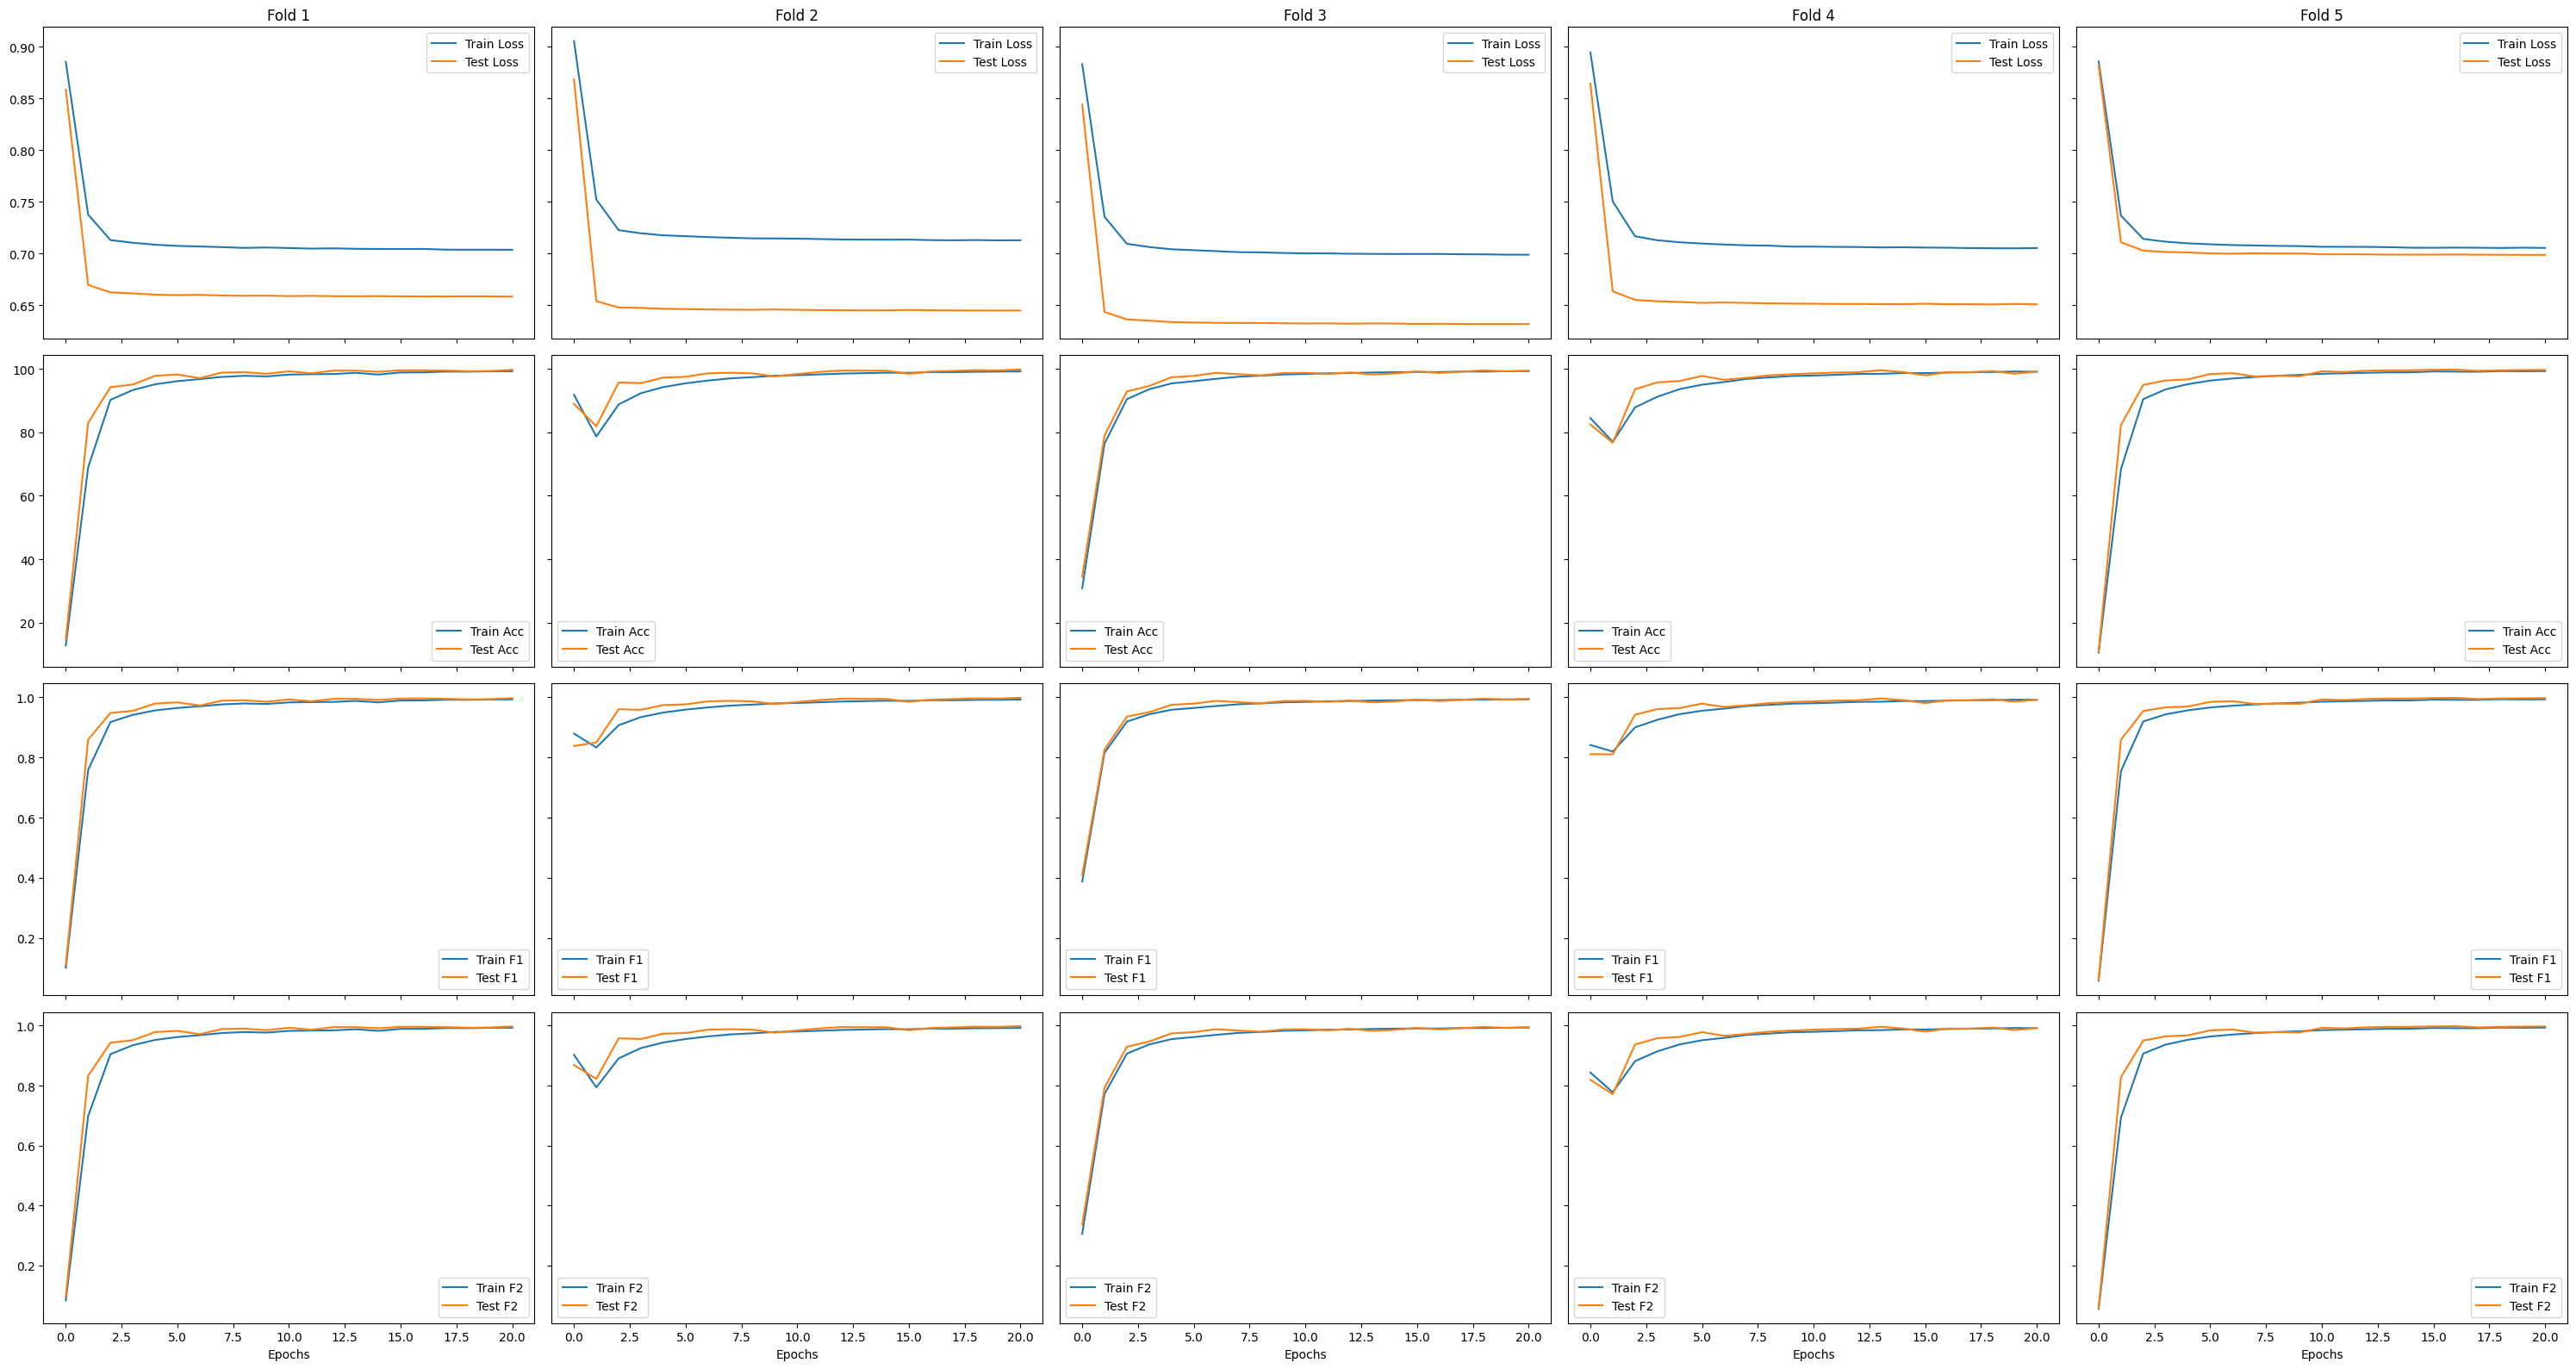

In [33]:
df_res = pd.DataFrame(columns=['Fold', 'accuracy', 'balanced_accuracy', 'f1', 'f2'], index=range(5))
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(30, 16), sharex=True, sharey='row')
for fold in range(5):
    d = results[fold]
    y = d['y_test']
    yhat = d['y_test_preds']
    df_res.iloc[fold] = [fold+1, accuracy_score(y, yhat), balanced_accuracy_score(y, yhat), f1_score(y, yhat, average='weighted'), fbeta_score(y, yhat, beta=2, average='weighted')]
    
    axes[0, fold].plot(d['train_losses'], label='Train Loss')
    axes[0, fold].plot(d['test_losses'], label='Test Loss')
    axes[0, fold].set_title(f'Fold {fold+1}')
    axes[1, fold].plot(d['train_accuracies'], label='Train Acc')
    axes[1, fold].plot(d['test_accuracies'], label='Test Acc')
    axes[2, fold].plot(d['train_f1s'], label='Train F1')
    axes[2, fold].plot(d['test_f1s'], label='Test F1')
    axes[3, fold].plot(d['train_f2s'], label='Train F2')
    axes[3, fold].plot(d['test_f2s'], label='Test F2')
    axes[3, fold].set(xlabel='Epochs')
for ax in axes.flat:
    ax.legend()
plt.tight_layout()
plt.show()

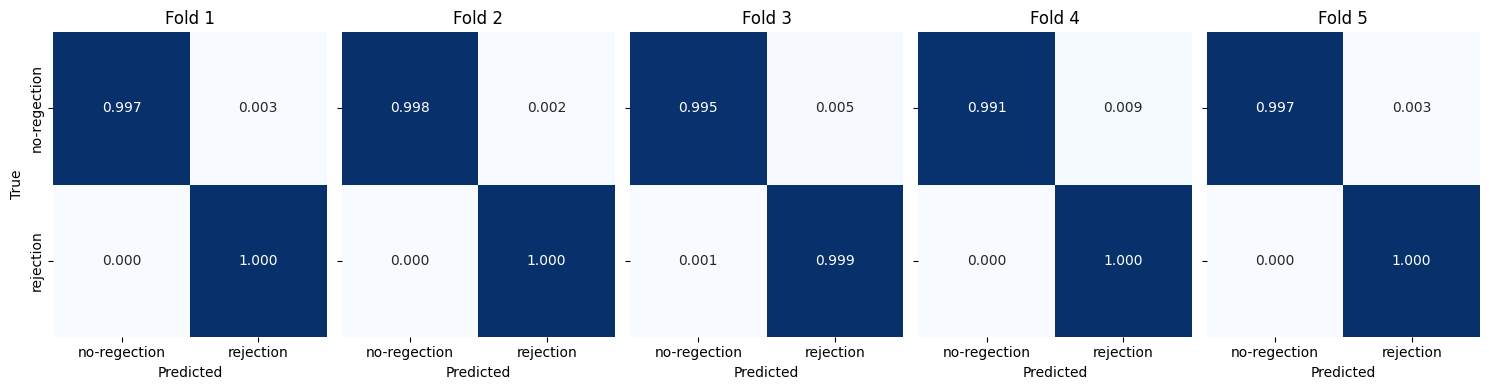

,Fold,accuracy,balanced_accuracy,f1,f2
0,1,0.997427,0.998349,0.997441,0.997429
1,2,0.998434,0.998901,0.998438,0.998434
2,3,0.995318,0.997037,0.995357,0.995322
3,4,0.991863,0.995329,0.991993,0.991876
4,5,0.997224,0.998358,0.997244,0.997227


In [34]:
class_names = ['no-regection', 'rejection']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4), sharey=True)
for fold in range(5):
    d = loaded_results[fold]
    y = d['y_test']
    yhat = d['y_test_preds']
    cm = confusion_matrix(y, yhat, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', cbar=False, ax=axes[fold])
    axes[fold].set_xlabel('Predicted')
    axes[fold].set_xticklabels(class_names)
    axes[fold].set_yticklabels(class_names)
    axes[fold].set_title('Fold {}'.format(fold+1))
axes[0].set_ylabel('True')
plt.tight_layout()
plt.show()
display(df_res)